In [1]:
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

with open("data/mol_bits.pkl", "rb") as f:
    mol_bits = pickle.load(f)

train = pd.read_csv("data/activity_train.csv", header=None)
train.columns = ["uniprot_id", "mol_id", "activity"]
train["mol_id"] = train["mol_id"].astype(str).str.strip()

test = pd.read_csv("data/activity_test_blanked.csv", header=None)
test.columns = ["uniprot_id", "mol_id", "activity"]
test["mol_id"] = test["mol_id"].astype(str).str.strip()

mol_ids = list(mol_bits.keys())

In [2]:
# Extracting unique features for sparse matrix dimensions
all_feats = set()
for feats_set in mol_bits.values():
    all_feats.update(feats_set)

n_feats = max(all_feats) + 1  # 0-based indexing

# Creating sparse matrix mol_feats
rows, cols = [], []
for i, (mol_id, feats_set) in enumerate(mol_bits.items()):
    rows.extend([i] * len(feats_set))
    cols.extend(feats_set)

mol_feats = csr_matrix(
    (np.ones(len(rows)), (rows, cols)), shape=(len(mol_bits), n_feats)
)

In [3]:
def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")  # initializes line sig
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()  # gets all docs as a set
            i = 0
            while len(L) > 0:
                elem = perm[i]  # get new element  from permutation
                docs_found = (
                    TDocs[elem] & L
                )  # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found) > 0:  # if anything was found
                    SIGS[list(docs_found), r] = (
                        i  #   set the line sig to the current position from the perm
                    )
                    L = (
                        L - docs_found
                    )  #   update the current list removing the found docs
                i += 1  # update the current position
                if i == M:  # this is the case that the document is empty
                    SIGS[list(L), r] = i  # Highly unlikely in a real data set
                    L = {}
                    # we have completed the signature for a given band,
                    # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets


def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    # transpose the data set
    DT = Data.T
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]
    P = B * R
    np.random.seed(3)
    # print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms = [np.random.permutation(M) for i in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

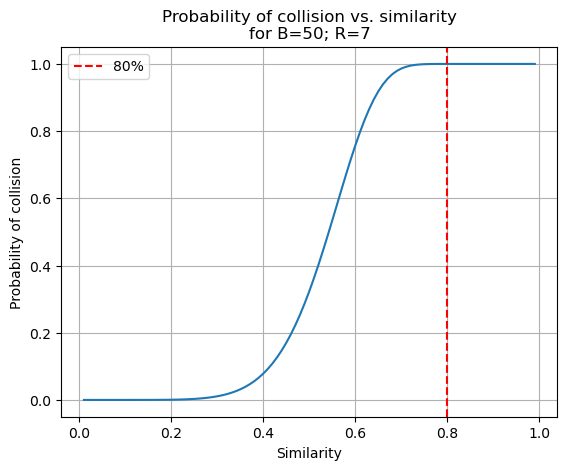

In [4]:
import matplotlib.pyplot as plt

# B = 50
# R = 10

B = 50
R = 7


S = np.arange(0.01, 1.0, 0.01)
P = 1 - (1 - S**R) ** B

plt.plot(S, P)
plt.xlabel("Similarity")
plt.ylabel("Probability of collision")
plt.axvline(0.80, color="red", linestyle="--", label="80%")
plt.title(f"Probability of collision vs. similarity\nfor B={B}; R={R}")
plt.grid()
plt.legend()
plt.show()

In [5]:
B = 50
R = 7

N, M = mol_feats.shape

buckets = LSHT(mol_feats.toarray(), B, R)

## Check in Test set where there where no collisions

In [6]:
all_nonempty_buckets = set()

for (b, buck), mols in buckets.items():
    if len(mols) > 1:
        all_nonempty_buckets.update(mols)

count = 0
for mol_id in test["mol_id"].unique():
    id = mol_ids.index(mol_id)
    if all_nonempty_buckets.intersection([id]) == set():
        count += 1
        # print(f"Test mol {mol_id} has no collisions")

print(f"Test set has {count} mols with no collisions")

Test set has 140 mols with no collisions


## Get Nearest Neighbors

In [69]:
# get all test set ids and get their index on mol_ids
test_ids = set(mol_ids.index(mol_id) for mol_id in test["mol_id"].unique())


def jaccard_similarity(id1, id2):
    set1 = set(mol_bits[mol_ids[id1]])
    set2 = set(mol_bits[mol_ids[id2]])
    return len(set1 & set2) / len(set1 | set2)


def get_all_neighbors(id, buckets):
    neighbors = set()
    for (b, buck), mols in buckets.items():
        if id in mols:
            neighbors.update(mols)
    neighbors.remove(id)
    neighbors.difference_update(test_ids)
    return neighbors


def k_neighbors(mol_idx, n_neighbors=5):
    neighbors = get_all_neighbors(mol_idx, buckets)

    neighbor_similarities = [
        (neighbor, jaccard_similarity(mol_idx, neighbor)) for neighbor in neighbors
    ]

    sorted_neighbors = sorted(neighbor_similarities, key=lambda x: x[1], reverse=True)

    return sorted_neighbors[:n_neighbors]

In [70]:
test_mols_neighbors = {}
for mol_id in test["mol_id"].unique():
    id = mol_ids.index(mol_id)
    neighbors = k_neighbors(id, n_neighbors=3)
    test_mols_neighbors[mol_id] = neighbors
    print(f"Neighbors for {mol_id}: {neighbors}")

Neighbors for CHEMBL2022258: [(4, 0.825), (16, 0.7816091954022989), (17, 0.7391304347826086)]
Neighbors for CHEMBL2047161: [(31, 0.797979797979798), (32, 0.797979797979798), (33, 0.797979797979798)]
Neighbors for CHEMBL2047163: [(16, 0.6759259259259259), (39, 0.6324786324786325), (17, 0.631578947368421)]
Neighbors for CHEMBL2047168: [(68, 0.719626168224299), (78, 0.719626168224299), (36, 0.7129629629629629)]
Neighbors for CHEMBL2047169: [(47, 0.7407407407407407), (68, 0.719626168224299), (78, 0.719626168224299)]
Neighbors for CHEMBL2048621: [(56, 0.6568627450980392), (61, 0.6442307692307693), (37, 0.6293103448275862)]
Neighbors for CHEMBL2048623: [(58, 0.782608695652174), (63, 0.6732673267326733), (25, 0.6590909090909091)]
Neighbors for CHEMBL207881: [(70, 0.5)]
Neighbors for CHEMBL4067052: [(93, 0.6901408450704225), (95, 0.6470588235294118), (92, 0.4625)]
Neighbors for CHEMBL4069191: [(104, 0.7294117647058823), (89, 0.7051282051282052), (106, 0.6463414634146342)]
Neighbors for CHEMBL4

In [73]:
with open("data/results/buckets.pkl", "wb") as f:
    pickle.dump(buckets, f)

with open("data/results/test_mols_neighbors.pkl", "wb") as f:
    pickle.dump(test_mols_neighbors, f)